# Kidney Cell Type Annotation using CellTypist

Installing necessary python libraries

In [1]:
!pip install anndata

  Using cached exceptiongroup-1.2.2-py3-none-any.whl.metadata (6.6 kB)
Using cached exceptiongroup-1.2.2-py3-none-any.whl (16 kB)



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
!pip install celltypist anndata scanpy

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 7.3/7.3 MB 2.3 MB/s eta 0:00:00
   ---------------------------------------- 2.1/2.1 MB 3.9 MB/s eta 0:00:00
   ---------------------------------------- 1.6/1.6 MB 4.0 MB/s eta 0:00:00
   ---------------------------------------- 2.0/2.0 MB 3.8 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8053 sha256=dd41626328e8031b949632ed756538c089a8884d959d0f60ad9510f1b8e9bafb
  Stored in directory: c:\users\preet\appdata\local\pip\cache\wheels\d4\fc\2e\00ca60bac7954b84907efd41baa9b4853500eaeec4228410c6
Successfully built session-info



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Importing dataset from HuBMap 

In [56]:
import anndata as ad
adata = ad.read_h5ad('expr.h5ad')

In [57]:
print(adata.obs.columns)

Index([], dtype='object')


Cleaning the dataset

In [58]:
#Step3: Run this code.
import anndata as ad

# Load original h5ad file
adata = ad.read_h5ad("E:/expr.h5ad")

# Check what's inside
print("OBS (cell metadata) columns:", adata.obs.columns)
print("VAR (gene metadata) columns:", adata.var.columns)

# Optional: Clean .obs (cell metadata)
# If empty, this won't change much, but ensure all are strings
adata.obs = adata.obs.astype(str)

# Clean .var (gene metadata)
# Option 1: Keep only the index (gene names), delete all metadata
adata.var = adata.var.iloc[:, :0]

# OR
# Option 2: Keep only specific useful columns, like 'hugo_symbol'
# adata.var = adata.var[['hugo_symbol']].astype(str)

# Optional: remove unnecessary layers if not needed
# adata.layers.clear()

# Save cleaned file
adata.write("E:/expr_fully_cleaned.h5ad")

print("✅ Cleaned h5ad file saved as 'expr_fully_cleaned.h5ad'")


OBS (cell metadata) columns: Index([], dtype='object')
VAR (gene metadata) columns: Index(['hugo_symbol'], dtype='object')
✅ Cleaned h5ad file saved as 'expr_fully_cleaned.h5ad'


In [59]:
print(adata)

AnnData object with n_obs × n_vars = 10999 × 60286
    layers: 'spliced', 'spliced_unspliced_sum', 'unspliced'


In [60]:
print(adata.obs.head())
print(adata.obs.columns)


Empty DataFrame
Columns: []
Index: [AAACCCAAGACTAAGT, AAACCCAAGACTCTAC, AAACCCAAGGAATGTT, AAACCCAAGGATATGT, AAACCCAAGGGCCCTT]
Index([], dtype='object')


Load the cleaned dataset and check gene and cell identifiers

In [62]:
import scanpy as sc
import celltypist
import anndata as ad

# Load your dataset
adata = ad.read_h5ad("E:/expr_fully_cleaned.h5ad")

# Quick check on the data
print(adata)
print("Genes:", adata.var_names[:5])
print("Cells:", adata.obs_names[:5])

AnnData object with n_obs × n_vars = 10999 × 60286
    layers: 'spliced', 'spliced_unspliced_sum', 'unspliced'
Genes: Index(['ENSG00000000003.15', 'ENSG00000000005.6', 'ENSG00000000419.13',
       'ENSG00000000457.14', 'ENSG00000000460.17'],
      dtype='object')
Cells: Index(['AAACCCAAGACTAAGT', 'AAACCCAAGACTCTAC', 'AAACCCAAGGAATGTT',
       'AAACCCAAGGATATGT', 'AAACCCAAGGGCCCTT'],
      dtype='object')


Checking the available pretrained models

In [31]:
celltypist.models.download_models()

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 54
📂 Storing models in C:\Users\preet\.celltypist\data\models
💾 Downloading model [1/54]: Immune_All_Low.pkl
💾 Downloading model [2/54]: Immune_All_High.pkl
💾 Downloading model [3/54]: Adult_COVID19_PBMC.pkl
💾 Downloading model [4/54]: Adult_CynomolgusMacaque_Hippocampus.pkl
💾 Downloading model [5/54]: Adult_Human_MTG.pkl
💾 Downloading model [6/54]: Adult_Human_PancreaticIslet.pkl
💾 Downloading model [7/54]: Adult_Human_PrefrontalCortex.pkl
💾 Downloading model [8/54]: Adult_Human_Skin.pkl
💾 Downloading model [9/54]: Adult_Human_Vascular.pkl
💾 Downloading model [10/54]: Adult_Mouse_Gut.pkl
💾 Downloading model [11/54]: Adult_Mouse_OlfactoryBulb.pkl
💾 Downloading model [12/54]: Adult_Pig_Hippocampus.pkl
💾 Downloading model [13/54]: Adult_RhesusMacaque_Hippocampus.pkl
💾 Downloading model [14/54]: Autopsy_COVID19_Lung.pkl
💾 Downloading model [15/54]: COVID19_HumanChallenge_Bloo

Importing necessary libraries from celltypist

In [63]:
from celltypist import models

Loading and preprocessing the data

In [64]:
# Load your data
adata = ad.read_h5ad("E:/expr_fully_cleaned.h5ad")

# Preprocessing required by CellTypist
sc.pp.normalize_total(adata, target_sum=1e4)  # Normalize total counts to 10,000 per cell
sc.pp.log1p(adata)                            # Logarithmize the data

# Optionally store raw for backup
adata.raw = adata.copy()

In [65]:
# Remove version numbers from Ensembl IDs
adata.var_names = adata.var_names.str.split('.').str[0]

Mapping Ensembl gene IDs (which are in your dataset) to HGNC gene symbols

In [66]:
import mygene
mg = mygene.MyGeneInfo()

# Query mapping
gene_info = mg.querymany(
    adata.var_names.tolist(),
    scopes='ensembl.gene',
    fields='symbol',
    species='human'
)

# Build mapping dictionary
mapping = {entry['query']: entry.get('symbol', entry['query']) for entry in gene_info}

# Apply the mapping
adata.var_names = [mapping.get(gene, gene) for gene in adata.var_names]


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
querying 1-1000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 1001-2000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 2001-3000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 3001-4000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 4001-5000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 5001-6000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 6001-7000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 7001-8000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 8001-9000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 9001-10000 ...
HTTP Request: POS

In [46]:
# Keep only genes that mapped to symbols (filter out Ensembl IDs that remain)
adata = adata[:, [not gene.startswith('ENSG') for gene in adata.var_names]]

In [47]:
import scanpy as sc

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata.copy()

In [49]:
adata.obs['cell_type'] = prediction.predicted_labels['majority_voting']


In [50]:
from celltypist import models

model = models.Model.load('Immune_All_Low.pkl')

# After running annotation
prediction = celltypist.annotate(
    adata,
    model=model,
    majority_voting=True
)

# Add predicted labels into your dataset
adata.obs['cell_type'] = prediction.predicted_labels['majority_voting']



🔬 Input data has 10999 cells and 44531 genes
🔗 Matching reference genes in the model
🧬 6048 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


In [51]:
adata.obs['cell_type'].value_counts()


cell_type
Epithelial cells            8212
Endothelial cells           1583
Alveolar macrophages         791
Tcm/Naive helper T cells     198
Fibroblasts                  119
NK cells                      53
Memory B cells                43
Name: count, dtype: int64

In [53]:
cell_counts = adata.obs['cell_type'].value_counts()
print(cell_counts)


cell_type
Epithelial cells            8212
Endothelial cells           1583
Alveolar macrophages         791
Tcm/Naive helper T cells     198
Fibroblasts                  119
NK cells                      53
Memory B cells                43
Name: count, dtype: int64


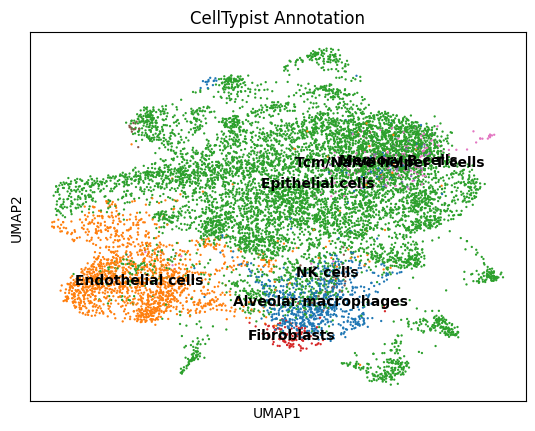

In [52]:
import scanpy as sc

# If UMAP is not already computed, do this:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

# Plot UMAP with cell types
sc.pl.umap(adata, color='cell_type', legend_loc='on data', title='CellTypist Annotation')


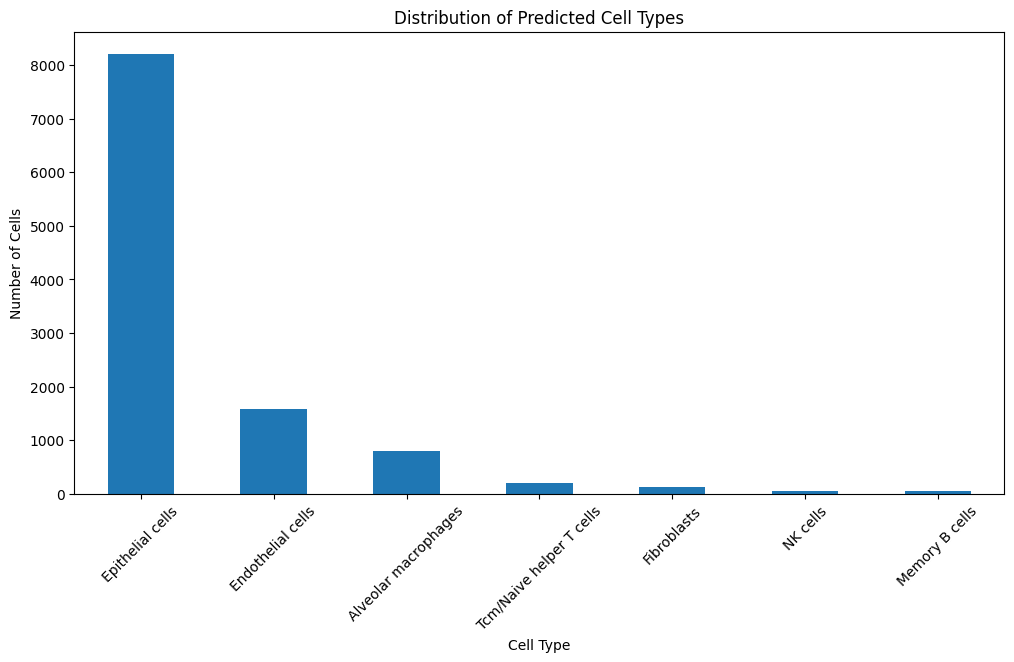

In [54]:
import matplotlib.pyplot as plt

cell_counts.plot(kind='bar', figsize=(12,6))
plt.xlabel('Cell Type')
plt.ylabel('Number of Cells')
plt.title('Distribution of Predicted Cell Types')
plt.xticks(rotation=45)
plt.show()
